In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
%matplotlib inline
from pathlib import Path
import functools
import itertools
from dataclasses import dataclass, fields

import pandas as pd
import numpy as np

import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
from matplotlib import rcParams 

In [4]:
from lib import datawrap #E
from lib import bar # artist
from lib import color, position # encoders


#spath = Path("../../../draft/figures/code/")
rcParams['figure.dpi'] = 200

In [5]:
data = {'fruit': ['apple', 'orange', 'lemon', 'lime'], 
       'calories':[95, 67, 17, 20], 
       'juice':[True, True, False, False]}
df = pd.DataFrame(data)

,fruit,calories,juice
0,apple,95,True
1,orange,67,True
2,lemon,17,False
3,lime,20,False


In [7]:
data_bounds = {('calories',):((20, 100), ), 
               ('juice', ): (None, ), 
               ('fruit',):(['orange', 'lemon', 'lime'], )}
tau = datawrap.FruitFrameWrapper(df)

In [8]:
tau.query(data_bounds)

[{'fruit': array(['orange', 'lime'], dtype=object),
  'calories': array([67, 20], dtype=int64),
  'juice': array([ True, False])}]

In [9]:
def broadcasted(f):
    def nub(values):
        if isinstance(values, str): return f(v)
        return [f(v) for v in values]
    return nub

In [10]:
# should K be up front or last?
def identity(val):
     return val

@broadcasted
def position_encoder(val):
    return {'apple': 0, 'orange': 2, 'lemon': 4, 'lime': 6}[val]

@broadcasted
def position_encoder_inverse(val):
    return {0:'apple', 2:'orange', 4:'lemon', 6:'lime'}.get(val, None)

def constant_color(c):
     return lambda x: [mcolors.to_rgba(c) for _ in range(x)]

def constant_value(val):
     return lambda x: [val for _ in range(x)]

    
def composite_x_transform(ax, nu):
    return lambda x: [ax.transData.transform((xi, 0))[0] for xi in nu(x)] # this needs to be broadcasted

def composite_y_transform(ax, nu):
     def f(y):
          return [ax.transData.transform((0, yi))[1] for yi in nu(y)]
     return f

def composite_x_distance_transform(ax, nu):
     def f(x):
          return [np.abs(ax.transData.transform((xi, 0)) 
                    - ax.transData.transform((0,0)))[0] for xi in nu(x)]
     return f

def composite_y_distance_transform(ax, nu):
     def f(y):
          return [np.abs(ax.transData.transform((0, yi)) 
                    - ax.transData.transform((0,0)))[1] for yi in nu(y)]
     return f


In [11]:
# multivariate nu, make key always a tuple ([possibly data class])
fruitPos = position.Nominal({'apple': 0, 'orange': 2, 'lemon': 4, 'lime': 6})
juiceCol = color.Nominal({True: 'navy', False: 'purple'})
fruitCol = color.Nominal({'apple': 'xkcd:red', 'orange': 'orange', 
                         'lemon': 'gold', 'lime': 'lime'})

In [12]:
def make_V(ax):
    V = [('length', ('calories',), composite_y_distance_transform(ax, identity), None), 
        ('position', ('fruit',), composite_x_transform(ax, position_encoder), position_encoder_inverse),
        ('floor', None,  composite_y_transform(ax, constant_value(0)), None), 
        ('width', None,  composite_x_distance_transform(ax, constant_value(.8)), None),
        ('edgecolor', ('juice',), juiceCol, juiceCol.inverse),
        ('facecolor', ('fruit',), fruitCol, fruitCol.inverse),
        ('linewidth', None, constant_value(5), None),
        ('linestyle', None, constant_value((0, None)), None)]
    return V

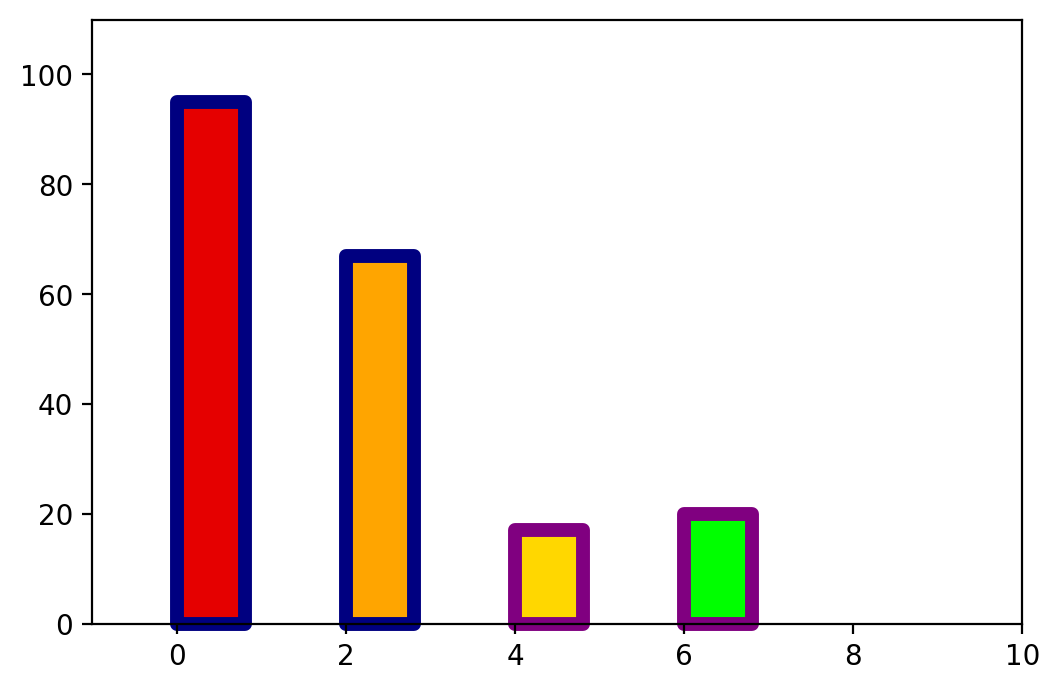

In [13]:
fig, ax = plt.subplots()
dbar = bar.Bar()
for (p, f, nu, nu_inv) in make_V(ax):
    pbar = dbar.compose_with_nu(p, f, nu, nu_inv)

axesArtist = bar.GenericArtist(pbar)
axesArtist.compose_with_tau(tau)
ax.add_artist(axesArtist)
ax.set(xlim=(-1, 10 ), ylim=(0, 110))
fig.savefig("../paper/figures/bar", bbox_inches='tight')

In [14]:
import matplotlib.image as mimage
from matplotlib.backends.backend_agg import RendererAgg

# this is what GenericArtist is doing

renderer = RendererAgg(500, 400, 100)
bounds, dpi = axesArtist.get_screen_bounds_to_data_bounds(renderer)
tau_r = axesArtist.data.query(bounds, dpi)
for tr in tau_r:
    mu = axesArtist..graphic.mu(tr)
    rho = axesArtist.artist.graphic.qhat(**mu)
    H = rho(renderer)

mimage.imsave('bar2.png', renderer.buffer_rgba(),
              format='png', origin='upper', dpi=100)


AttributeError: 'Bar' object has no attribute 'data'

In [27]:
def make_VH(ax):
    V = [('length', ('calories',), composite_x_distance_transform(ax, identity), None), 
        ('position', ('fruit',), composite_y_transform(ax, position_encoder), position_encoder_inverse),
        ('floor', None,  composite_y_transform(ax, constant_value(0)), None), 
        ('width', None,  composite_y_distance_transform(ax, constant_value(.8)), None),
        ('edgecolor', ('juice',), juiceCol, juiceCol.inverse),
        ('facecolor', ('fruit',), fruitCol, fruitCol.inverse),
        ('linewidth', None, constant_value(5), None),
        ('linestyle', None, constant_value((0, None)), None)]
    return V

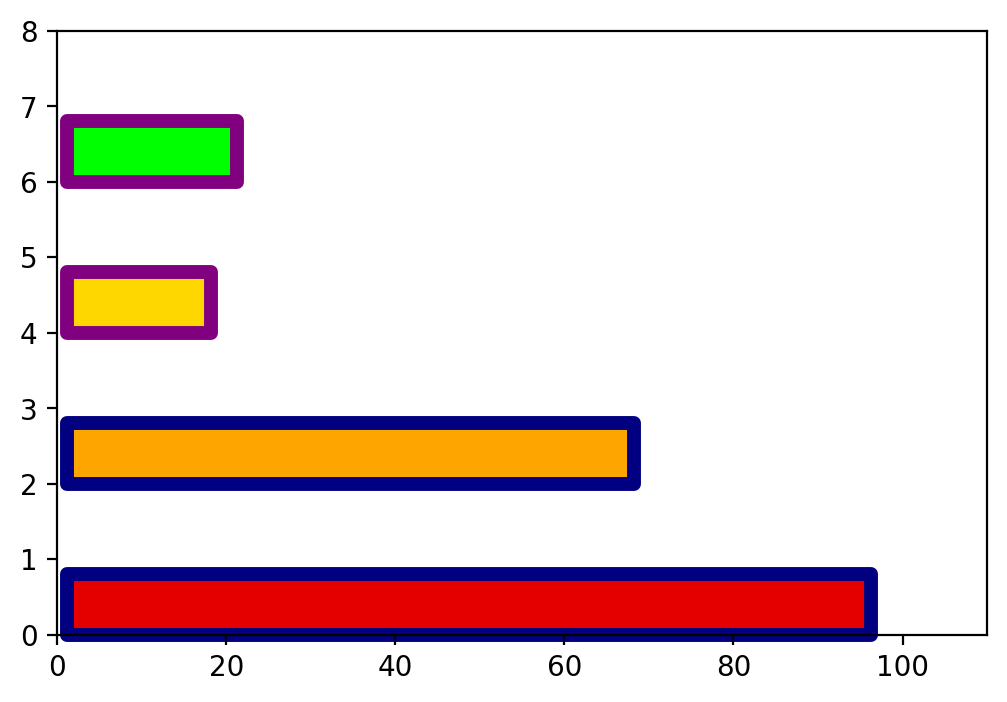

In [31]:
fig, ax = plt.subplots()
dbarh = bar.BarH()
for (pi, fi, nui, nu_inv) in make_VH(ax):
      pbarh = dbarh.compose_with_nu(pi, fi, nui)

axesArtisth = bar.GenericArtist(pbarh)
axesArtisth.compose_with_tau(tau)
ax.add_artist(axesArtisth)
ax.set(ylim=(0,8), xlim=(0, 110))
fig.savefig("../paper/figures/barh", bbox_inches='tight')

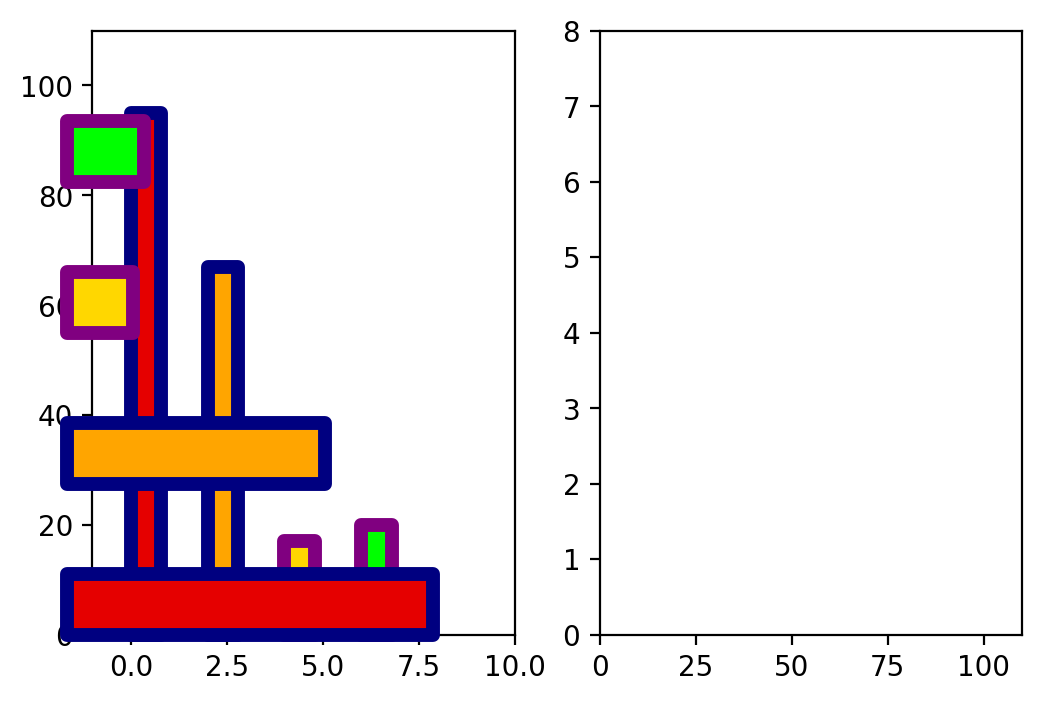

In [26]:
fig, (ax1, ax2) = plt.subplots(ncols=2)

dbar = bar.Bar()

for (p, f, nu, nu_inv) in make_V(ax1):
    pbar = dbar.compose_with_nu(p, f, nu, nu_inv)

axesArtist = bar.GenericArtist(pbar)
axesArtist.compose_with_tau(tau)
ax1.add_artist(axesArtist)
ax1.set(xlim=(-1, 10 ), ylim=(0, 110))


dbarh = bar.BarH()
for (pi, fi, nui, nu_inv) in make_VH(ax2):
      pbarh = dbarh.compose_with_nu(pi, fi, nui)

axesArtisth = bar.GenericArtist(pbarh)
axesArtisth.compose_with_tau(tau)
ax2.add_artist(axesArtisth)
ax2.set(ylim=(0,8), xlim=(0, 110))

fig.savefig("../paper/figures/barboth", bbox_inches='tight')
